In [1]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/avic/OOD_Orientation_Generalization')
from my_dataclasses import *
from train.dataset import *
from train.train import *
from tools import get_all_generated_canonical_heatmaps, get_heatmap_cell_ranges2
import seaborn as sns
from pandas.api.types import CategoricalDtype
import itertools
import functools
from sklearn.preprocessing import normalize
from matplotlib_venn import *
from sklearn.preprocessing import minmax_scale
plt.style.use('default')

In [2]:
def get_unrestricted_axis(restricted_axes):
    if restricted_axes[1] == '1':
        return 0
    if restricted_axes[4] == '1':
        return 2
    return 1

BASE_PATH = '/home/avic/OOD_Orientation_Generalization'

def get_exps_frame(exp_iter):
    exps_frame = pd.read_csv(os.path.join(BASE_PATH, f'exps{exp_iter}.csv'), index_col=[5,2])
    exps_frame = exps_frame[exps_frame.model_type == 'ModelType.ResNet']
    exps_frame = exps_frame[exps_frame.hole != 2]
    exps_frame = exps_frame[~exps_frame.pretrained & ~exps_frame.scale]
    exps_frame = exps_frame[~(exps_frame.training_category == 'lamp')]
    exps_frame['run'] = exp_iter
    exps_frame['pred_model_i'] = exps_frame.restriction_axes.apply(get_unrestricted_axis) + exps_frame.hole
    
    fits = pd.read_csv(os.path.join(BASE_PATH, f'fits/exp{exp_iter}_fits.csv')).reset_index()
    
    joined_subset = exps_frame.merge(fits, on=['num', 'data_div', 'unrestricted_axis'])
    return joined_subset

In [3]:
exps_frames = pd.concat([get_exps_frame(exp_iter) for exp_iter in range(1, 4)]).reset_index()

In [4]:
models = get_all_generated_canonical_heatmaps()[:4]

In [5]:
def sig(arr, x, y, z):
    return np.divide(1, 1 + np.exp(((-np.power(arr, x)) + y) * z))

def fitted_model(exp):
    
    exp_model = models[exp.pred_model_i]
    
    CA0, CA1, CA2, CE0, CE1, CE2, CAf0, CAf1, CAf2, CEf0, CEf1, CEf2 = exp[44:-1]
    
    component_args = [
        [CA0, CA1, CA2],
        [CE0, CE1, CE2],
        [CAf0, CAf1, CAf2],
        [CEf0, CEf1, CEf2]
    ]
    
    return np.sum(np.stack([sig(exp_model[x], *component_args[x]) for x in range(4)]), axis=0)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
# exp = exps_frames[exps_frames.job_id == 31].iloc[0]#exps_frames.iloc[15]

# heatmap = np.load(exp.eval_heatmap)
# fitted = fitted_model(pred_models[exp.pred_model_i], exp)

plt.close('all')

THRESH = 0.1

exps = exps_frames[:12][exps_frames.data_div == 40]
_, axes = plt.subplots(12, 20, figsize=(40, 15))
for x in range(3):
    exp = exps.iloc[x]
    h = np.nan_to_num(np.load(exp.eval_heatmap))

    m = fitted_model(exp)
    
    ha = h.copy()
    mask = (NormalizeData(m) > THRESH)
    ha[mask] = 0
    
    for y in range(20):
        
        a = [2, 0, 1][x]
        if a == 0:
            s = np.s_[y]
        if a == 1:
            s = np.s_[:, y]
        else:
            s = np.s_[..., y]

        axes[(x * 4), y].imshow(h[s], norm=plt.Normalize(vmin=0, vmax=1))
        axes[(x * 4) + 1, y].imshow(m[s], norm=plt.Normalize(vmin=0, vmax=1))
        axes[(x * 4) + 2, y].imshow(mask[s], norm=plt.Normalize(vmin=0, vmax=1))
        axes[(x * 4) + 3, y].imshow(ha[s], norm=plt.Normalize(vmin=0, vmax=1))

In [ ]:
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn import metrics

def l1_norm(arr):
    return (arr - arr.mean()) / arr.std()
    return arr / np.linalg.norm(arr, 1)

def my_pierson(x, y):
    x_avg = np.expand_dims(np.mean(x, axis=-1), axis=-1)
    y_avg = np.expand_dims(np.mean(y, axis=-1), axis=-1)
    x_std = np.std(x, axis=-1)
    y_std = np.std(y, axis=-1)

    return (((x - x_avg) @ (y - y_avg)) / ((x_std * y_std) * (x.shape[-1])))

In [6]:
bin_ranges = np.array(
    [[[-5, 5],
      [-0.25, 0.25],
      [-0.25, 0.25]],
     [[-0.25, 0.25],
      [-5, 5],
      [-0.25, 0.25]],
     [[-0.25, 0.25],
      [-0.25, 0.25],
      [-5, 5]]])

def threshold_model(exp):
    threshs = np.linspace(0, 10, 1000)
    exp_heatmap = np.load(exp.eval_heatmap)
    exp_fitted_model = fitted_model(exp)
    thresh = threshs[np.argmin(np.mean((np.expand_dims(exp_fitted_model, -1) > np.expand_dims(threshs, (0, 1, 2))) ^ np.expand_dims((exp_heatmap > 0.2), -1), axis=(0, 1, 2)))]
    return exp_fitted_model > thresh

thresholded_model = threshold_model(exps_frames.iloc[3])[..., 10]

def classify_image_patterns(exp, df, thesholded_model):
    xs, ys, zs = get_heatmap_cell_ranges2(20)
    cubelet_ranges = np.array(list(itertools.product(*[np.stack([vs[:-1], vs[1:]]).T for vs in [xs, ys, zs]]))).reshape(20, 20, 20, 3, 2)[:,:,10]
    
    bin_range = bin_ranges[exp.pred_model_i]
    
    df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
    # df['outside_model'] = ~df.in_bin & functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2])), tqdm(cubelet_ranges[~thesholded_model]), False)
    df['outside_model'] = ~df.in_bin & functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1])), tqdm(cubelet_ranges[~thesholded_model]), False)
    df['in_model'] = ~df.in_bin & ~df.outside_model
    df['cubelet_i'] = functools.reduce(lambda a, b: a + (b[0] * (df.object_x.between(*b[1][0], inclusive='left') & df.object_y.between(*b[1][1], inclusive='left'))), tqdm(enumerate(cubelet_ranges.reshape(400, 3, 2))), 0)

    # df.cubelet_i = pd.Series(list(np.stack(np.unravel_index(dfs[3][0].cubelet_i, (20, 20))).T))
    df['pattern'] = (df.in_bin + (df.outside_model * 2) + (df.in_model * 3)).apply(lambda x: ['none', 'bin', 'outside_model', 'in_model'][x])

In [7]:
def get_df(x):
    exp = exps_frames.iloc[x]
    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = np.load(exp_dataclass.image_activations)
    norm_image_activations = image_activations / np.max(image_activations, axis=0)

    rd = RotationDataset(exp_dataclass)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

    classify_image_patterns(exp, df, thresholded_model)
    

    df['seen'] = df.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])
    df['#seen'] = exp.data_div

    return df, norm_image_activations

dfs = [get_df(x) for x in range(4)]

100%|██████████| 208/208 [00:00<00:00, 697.72it/s]
400it [00:00, 501.41it/s]
100%|██████████| 208/208 [00:00<00:00, 703.89it/s]
400it [00:00, 504.61it/s]
100%|██████████| 208/208 [00:00<00:00, 694.20it/s]
400it [00:00, 512.33it/s]
100%|██████████| 208/208 [00:00<00:00, 700.46it/s]
400it [00:00, 510.39it/s]


In [128]:
average_activation = pd.concat([df.groupby(['model_name', 'cubelet_i', 'seen', '#seen']).apply(lambda group: np.nanmean(norm_image_activations[group.index], axis=0)).explode().astype(float).to_frame('average_activation').reset_index() for df, norm_image_activations in tqdm(dfs)])

100%|██████████| 4/4 [00:22<00:00,  5.58s/it]


In [165]:
average_activation['neuron'] = list(range(512)) * len(pd.unique(average_activation.model_name)) * 400 * len(pd.unique(average_activation['#seen']))
average_activation['thresholded_activation'] = average_activation.average_activation > 0.1

ValueError: Length of values (40960000) does not match length of index (307200)

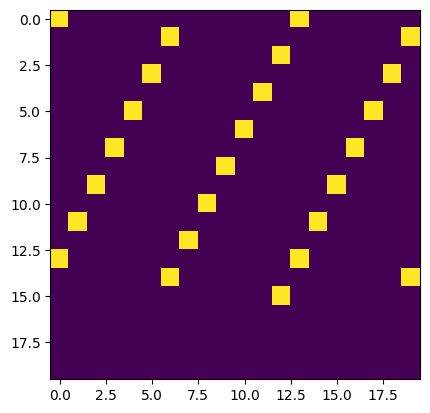

In [158]:
chosen_cubelets = np.zeros((400))
for x in range(25):
    chosen_cubelets[x * 13] = 1
plt.imshow(chosen_cubelets.reshape(20, 20))

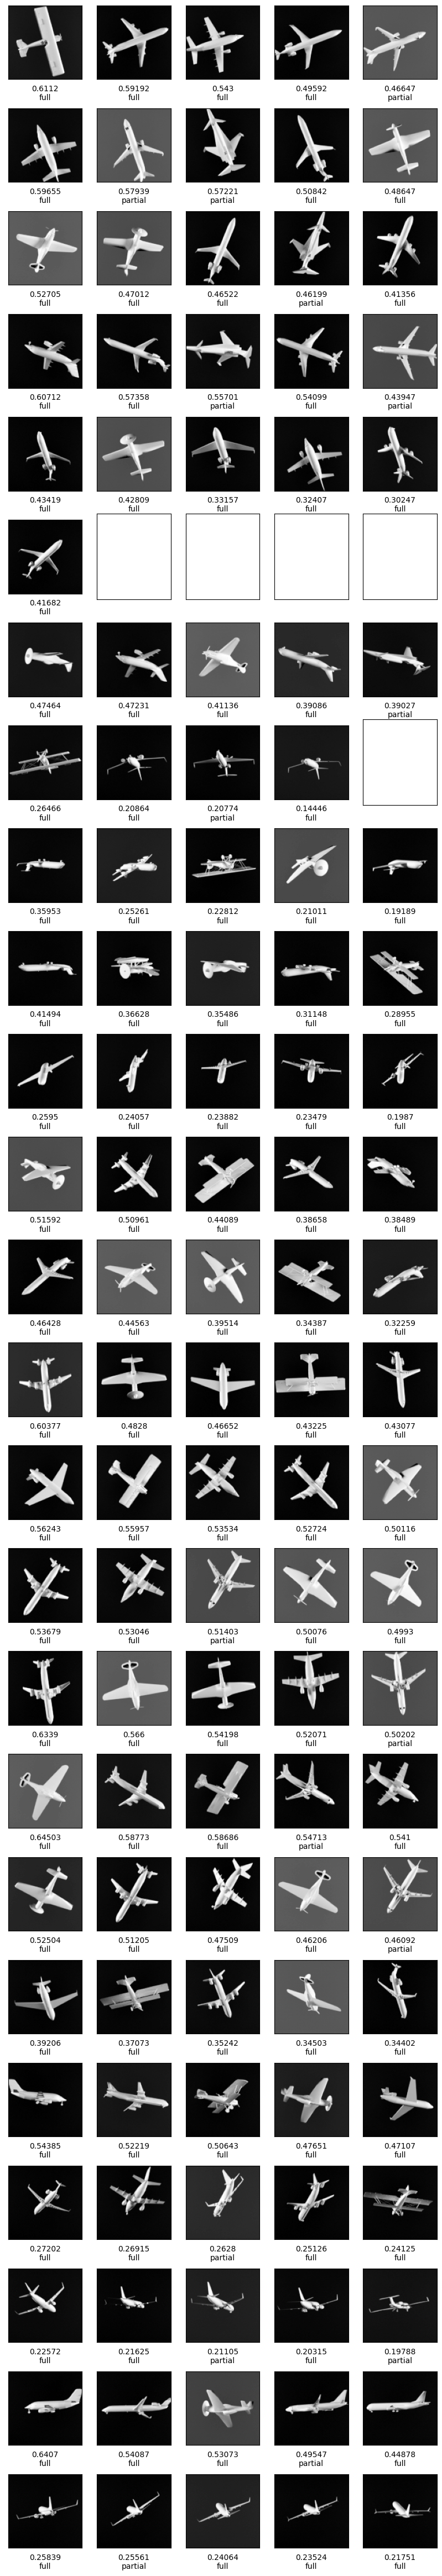

In [159]:
plt.style.use('default')
df = dfs[3][0]
plt.close('all')
_, axes = plt.subplots(25, 5, figsize=(10, 60))
for x in range(25):
    cubelet_i = 13 * x
    neuron = 1
    sorted_average_activations = average_activation[(average_activation['#seen'] == 40) & (average_activation.neuron == neuron) & (average_activation.cubelet_i == cubelet_i)].sort_values('average_activation', ascending=False)
    for y, b in enumerate((minmax_scale(sorted_average_activations.average_activation) > 0.5)[:5]):
        if b:
            image_name = df.iloc[np.abs(df[(df.model_name == sorted_average_activations.model_name.iloc[y]) & (df.cubelet_i == cubelet_i)].object_z).sort_values().index[0]].image_name
            axes[x][y].imshow(plt.imread(image_name)[55:-55, 55:-55], cmap='gray')
            axes[x][y].set_xlabel(f'{round(sorted_average_activations.average_activation.iloc[y], 5)}\n{sorted_average_activations.seen.iloc[y]}')
        axes[x][y].set_xticks([])
        axes[x][y].set_yticks([])

In [ ]:
def get_invariance(pre_act, post_act):
    image_invariances = 1 - np.abs((post_act - pre_act) / (post_act + pre_act))

    return np.nanmean(np.where((post_act > 0.2) | (pre_act > 0.2), image_invariances, np.nan), axis=0)

def group_invariance(group, norm_image_activation):

    bin_activation = np.nanmean(norm_image_activation[df[(df.model_name == group.name[0]) & df.in_bin].index], axis=0)
    group_image_activations = norm_image_activation[group.index]

    return get_invariance(bin_activation, group_image_activations)

invariance = pd.concat([df.groupby(['model_name', 'seen', 'pattern', '#seen']).apply(group_invariance, norm_image_activation).explode().astype(float).to_frame('invariance').reset_index() for df, norm_image_activation in tqdm(dfs)])

In [ ]:
sns.catplot(kind='violin', data=invariance, col='#seen', x='pattern', y='invariance', split=True, hue='seen', hue_order=['full', 'partial'])

In [ ]:
def get_mixed_selectivity(group, norm_image_activations, fully_seen_model_activations):

    group_image_activations = norm_image_activations[group.index]

    image_invariances = np.stack(fully_seen_model_activations[fully_seen_model_activations.pattern == group.name[2]].average_activation.apply(lambda inv: get_invariance(inv, group_image_activations)).values)

    return image_invariances.max(axis=0)

mixed_selectivity = pd.concat([df.groupby(['model_name', 'seen', 'pattern', '#seen']).apply(get_mixed_selectivity,
        norm_image_activations,
        df[df.seen == 'full'].groupby(['model_name', 'pattern']).apply(lambda group: np.nanmean(norm_image_activations[group.index], axis=0)).to_frame('average_activation').reset_index()).explode().astype(float).to_frame('mixed selectivity').reset_index() for df, norm_image_activations in tqdm(dfs)])

In [ ]:
sns.catplot(kind='violin', data=mixed_selectivity, col='#seen', x='pattern', y='mixed selectivity', split=True, hue='seen', hue_order=['full', 'partial'])

In [10]:
average_activation = pd.concat([df.groupby(['model_name', 'seen', 'pattern', '#seen']).apply(lambda group: np.nanmean(norm_image_activations[group.index], axis=0)).explode().astype(float).to_frame('average_activation').reset_index() for df, norm_image_activations in tqdm(dfs)])

100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


In [11]:
average_activation['neuron'] = list(range(512)) * len(pd.unique(average_activation.model_name)) * 3 * len(pd.unique(average_activation['#seen']))
average_activation['thresholded_activation'] = average_activation.average_activation > 0.1

In [ ]:
sns.catplot(kind='violin', data=average_activation, col='#seen', x='pattern', y='average_activation', split=True, hue='seen', hue_order=['full', 'partial'])

In [196]:
average_activation['neuron'] = list(range(512)) * len(pd.unique(average_activation.model_name)) * len(pd.unique(average_activation.pattern)) * len(pd.unique(average_activation['#seen']))
average_activation['thresholded_activation'] = average_activation.average_activation > 0.1

In [22]:
def spread(arr):
    return np.nanmean(np.abs(arr) ** 2) / np.std(np.abs(arr))

def selectivity(arr):
    # arr = arr / arr.max()
    S = np.mean(np.expand_dims(arr, axis=-1) > np.expand_dims(np.linspace(0, 1, 100), axis=0))
    return 1 - (2 * S)

In [23]:
selectivity = average_activation.groupby(['neuron', 'seen', 'pattern', '#seen']).apply(lambda group: selectivity(group.average_activation)).to_frame('selectivity').reset_index()

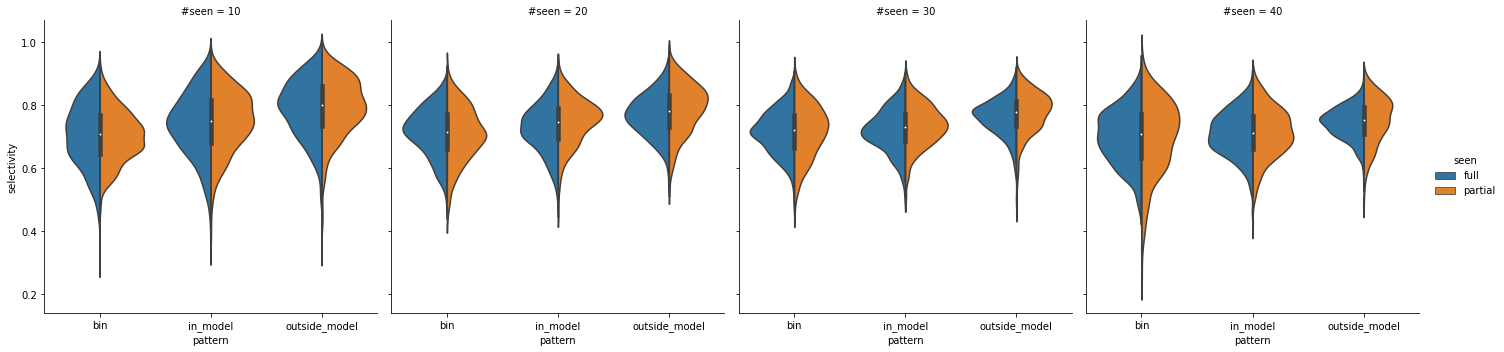

In [24]:
sns.catplot(kind='violin', data=selectivity, col='#seen', x='pattern', y='selectivity', split=True, hue='seen', hue_order=['full', 'partial'])

In [26]:
max_activation = average_activation.groupby(['neuron', 'seen', 'pattern', '#seen']).apply(lambda group: np.max(group.average_activation)).to_frame('max_activation').reset_index()

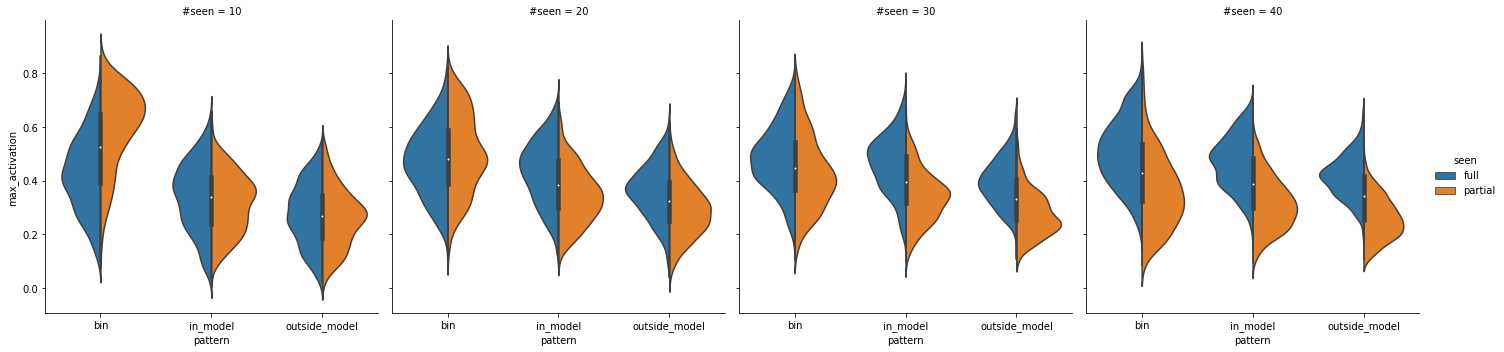

In [27]:
sns.catplot(kind='violin', data=max_activation, col='#seen', x='pattern', y='max_activation', split=True, hue='seen', hue_order=['full', 'partial'])

In [ ]:
plt.style.use('default')
sns.catplot(kind='swarm', data=average_activation[average_activation.neuron < 10], col='#seen', row='neuron', x='pattern', y='average_activation', split=True, hue='seen', hue_order=['full', 'partial'])

In [375]:
def canonical_array(group):
    c_imgs = canonical_images[group.iloc[np.argpartition(group.average_activation, -4)[-4:]].model_name]
    imgs = np.array([plt.imread(img)[55:-55, 55:-55] for img in c_imgs])
    return np.vstack([np.hstack([imgs[0], imgs[1]]), np.hstack([imgs[2], imgs[3]])])

highest_imgs = average_activation[average_activation.neuron < 10].groupby(['neuron', 'seen', 'pattern', '#seen']).apply(canonical_array).to_frame('combined_image').reset_index()

In [377]:
average_activation.merge(highest_imgs, on=['seen', 'pattern', '#seen', 'neuron'])

,model_name,seen,pattern,#seen,average_activation,neuron,thresholded_activation,combined_image
0,151550551758af098b96ae1a0a8b84ec,partial,bin,10,0.038332,0,False,"[[0.30588236, 0.30588236, 0.30588236, 0.305882..."
1,23d5975dd63000eb4e901b3386f76d65,partial,bin,10,0.024006,0,False,"[[0.30588236, 0.30588236, 0.30588236, 0.305882..."
2,3572e3fa25911295922e63c830b776de,partial,bin,10,0.033355,0,False,"[[0.30588236, 0.30588236, 0.30588236, 0.305882..."
3,3ca058682dfe98f7f678b53750b6d181,partial,bin,10,0.170536,0,True,"[[0.30588236, 0.30588236, 0.30588236, 0.305882..."
4,4100df683795dfa1f95dfd5eb5f06d19,partial,bin,10,0.013384,0,False,"[[0.30588236, 0.30588236, 0.30588236, 0.305882..."
...,...,...,...,...,...,...,...,...
5995,b3a59a941500e76535592b447835a16e,partial,outside_model,40,0.119452,9,True,"[[0.30588236, 0.30588236, 0.30588236, 0.305882..."
5996,b6d2c4beaec0520e9a6e43b878d5b335,partial,outside_model,40,0.382570,9,True,"[[0.30588236, 0.30588236, 0.30588236, 0.305882..."
5997,da3ed25d281fc4c065fc5f76098aceb0,partial,outside_model,40,0.125038,9,True,"[[0.30588236, 0.30588236, 0.30588236, 0.305882..."
5998,e9dcdcd8963ba18f42bc0eea174f82b,partial,outside_model,40,0.124591,9,True,"[[0.30588236, 0.30588236, 0.30588236, 0.305882..."


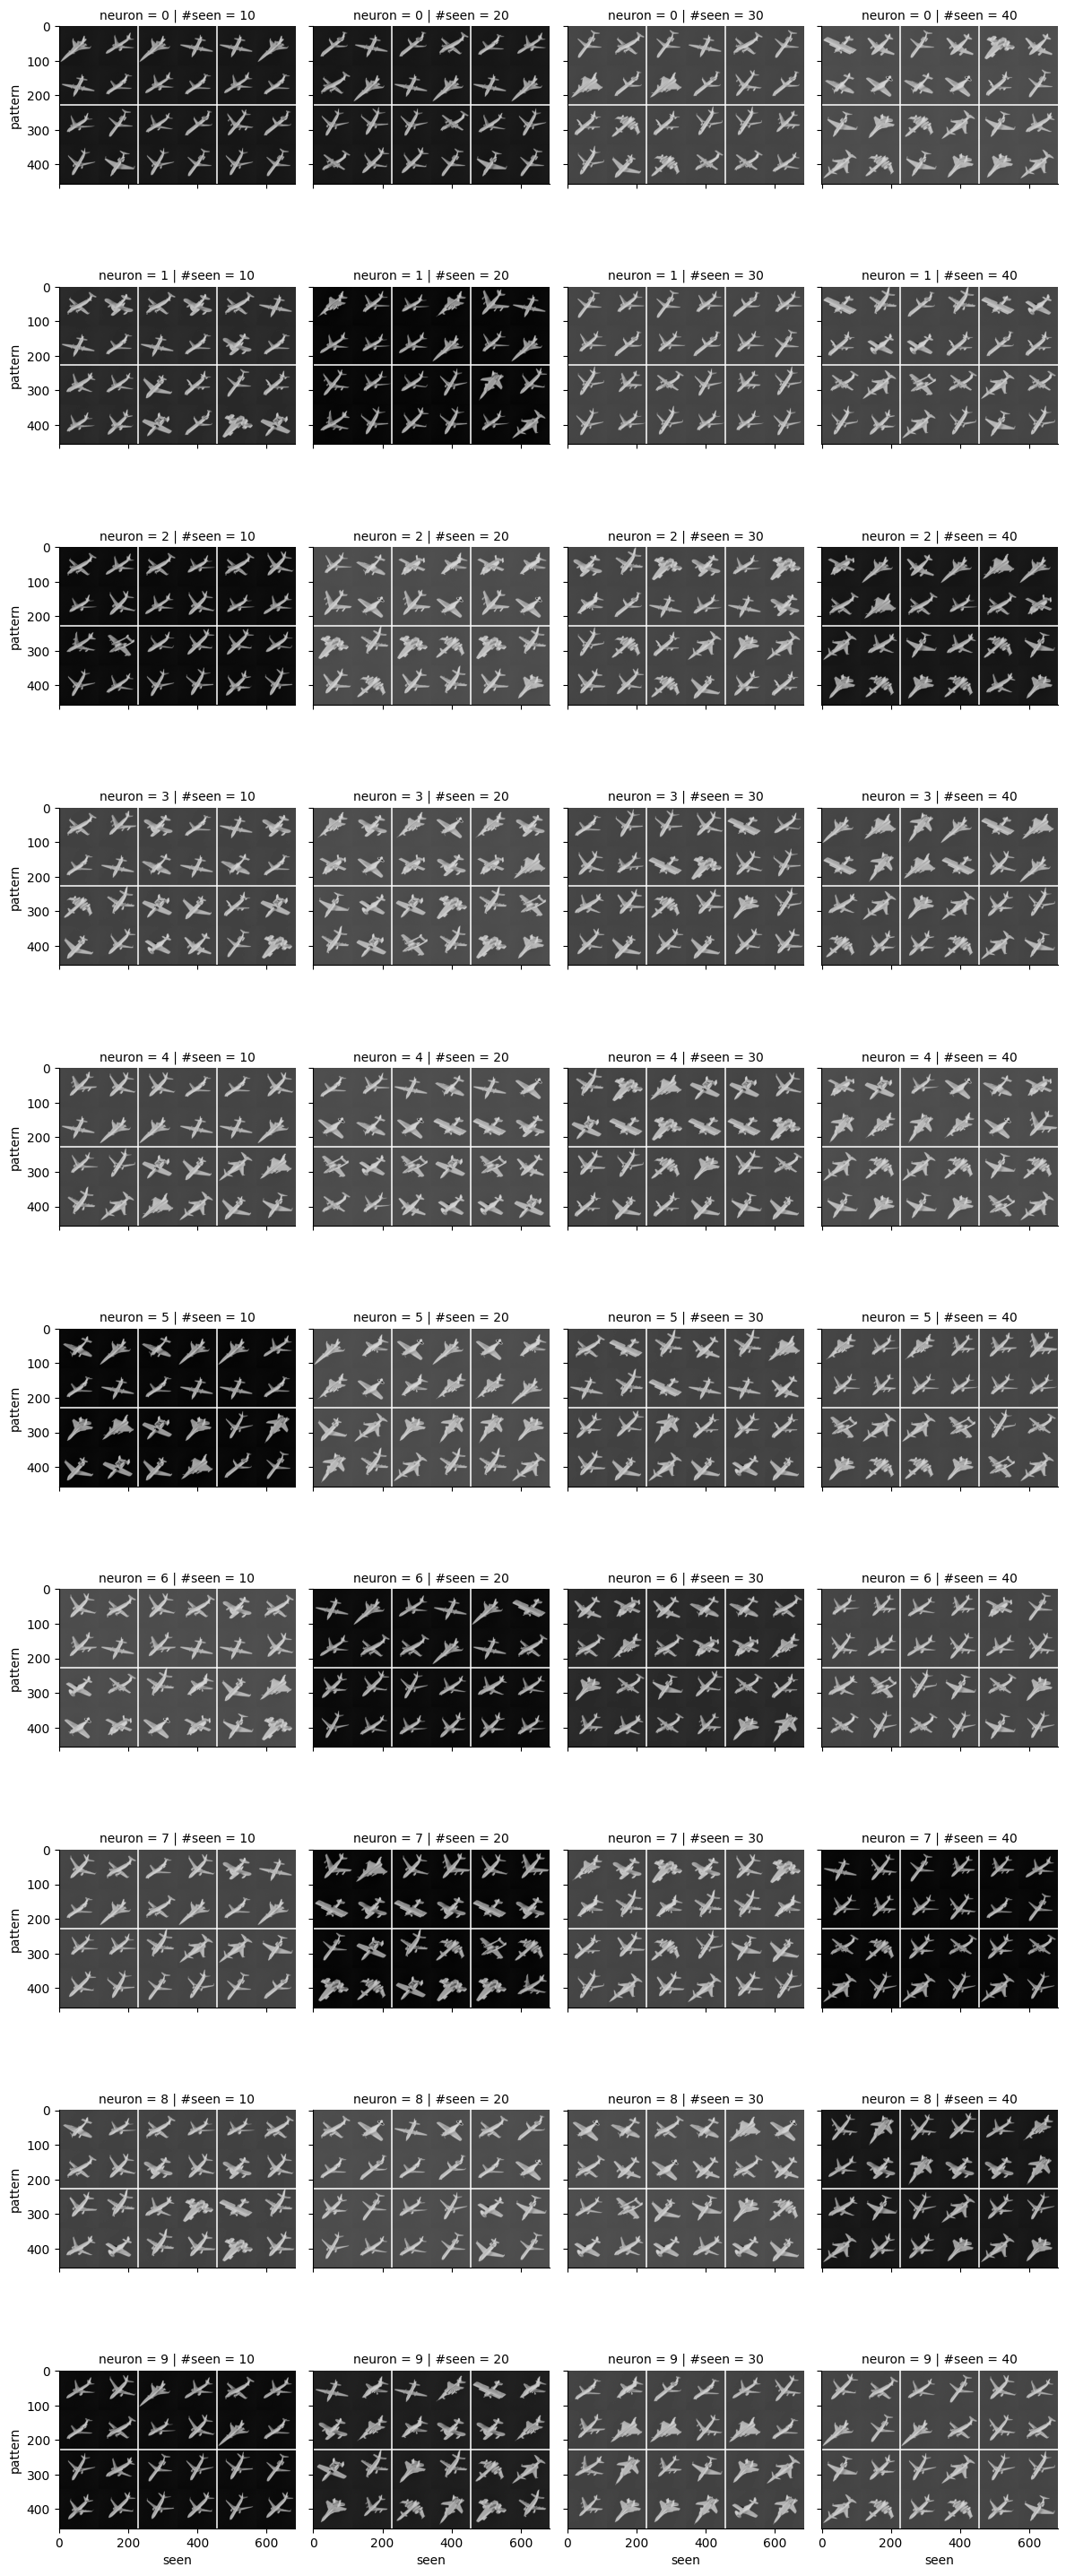

In [376]:
def q(seen, neuron, num_seen):
    combined_image = selected_rows = highest_imgs[(highest_imgs.neuron == neuron) &
           (highest_imgs['#seen'] == num_seen) &
           (highest_imgs.seen == seen)]
    for y in (228, 228 * 2):
        combined_image[:, y - 2: y+2] = 1
    return combined_image


def myplot(seen, pattern, imgs, neuron, num_seen, **kwargs):
    # _, axes = plt.subplots(2, 3)
    # print(imgs)
    all_images = np.vstack([
        q('full', neuron.iloc[0], num_seen.iloc[0]),
         q('partial', neuron.iloc[0], num_seen.iloc[0])])
    
    all_images[226:230] = 1
    plt.imshow(all_images, cmap='gray')

g = sns.FacetGrid(highest_imgs, col='#seen', row='neuron')
g.map(myplot, 'seen', 'pattern', 'combined_image', 'neuron', '#seen')

In [352]:
res = average_activation.merge(selectivity, on=['seen', 'pattern', '#seen', 'neuron']).sort_values('selectivity')

In [205]:
image_df = pd.read_csv(RotationDataset(ExpData.get_experiments(3)).testing.full.path.merged_annotation_path())

In [257]:
canonical_orientation = (-0.7, 0.7, np.pi)
canonical_images = image_df.groupby('model_name').apply(lambda group: group.iloc[\
            np.argmin(np.abs(group.object_x - canonical_orientation[0])\
                      + np.abs(group.object_y - canonical_orientation[1])\
                      + np.abs(group.object_z - canonical_orientation[2]))].image_name)

In [170]:
plt.close('all')

  0%|          | 0/5 [00:01<?, ?it/s]


AttributeError: 'Series' object has no attribute 'neuron_images'

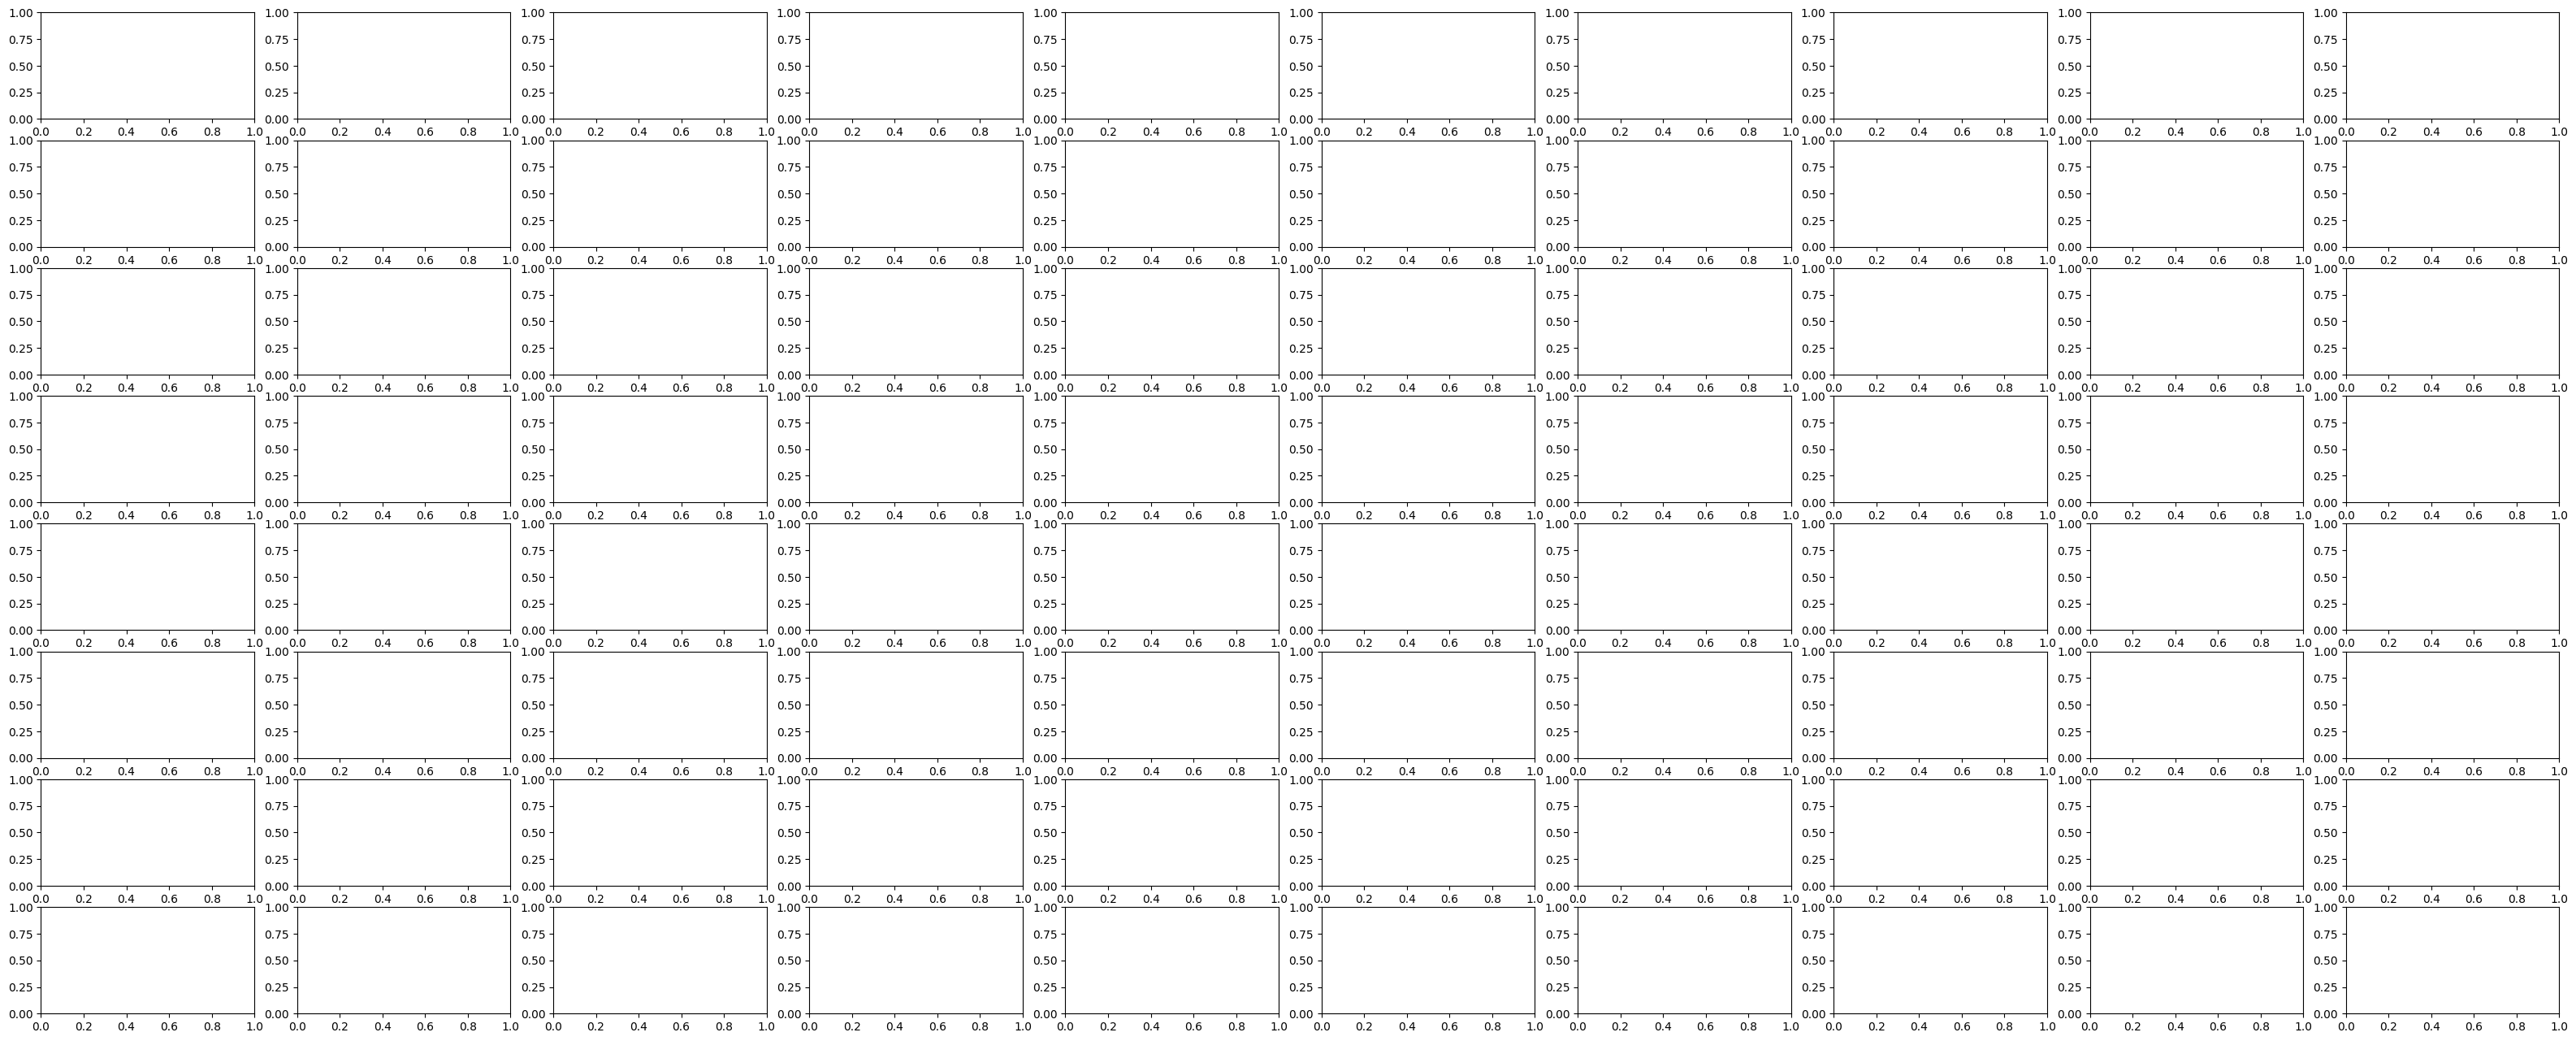

In [171]:
plt.style.use('default')
plt.close('all')
for z in tqdm(range(5)):
    rows = average_activation[(average_activation['#seen'] == 40) & average_activation.thresholded_activation & (average_activation.neuron == z)].reset_index()
    rows = rows.sort_values('average_activation', ascending=False)
    if len(rows) < 10:
        continue
    
    _, axes = plt.subplots(len(rows) // 10, 10, figsize=(5 * (len(rows) // 10), 2 * (len(rows) // 10)))
    for x in range(len(rows) // 10):
        for y in range(10):
            row = rows.iloc[(x * 10) + y]
            subplot = axes[x][y] if len(rows) >= 20 else axes[y]
            subplot.imshow(plt.imread(row.neuron_images)[50:-50,50:-50], cmap='gray', vmin=0, vmax=1)
            subplot.set_xticks([])
            subplot.set_yticks([])
            subplot.set_xlabel(round(row.average_activation, 5))
    plt.tight_layout()
    plt.savefig(f'./neuron_images/neuron{z}_images.png', dpi=300)

In [ ]:
invariances = df.groupby(['model_name', 'seen', 'pattern']).apply(a).reset_index()
group1_invariances = invariances[(invariances.seen == 'partial') & (invariances.pattern == 'in_model')].iloc[0][0]
np.argpartition(group1_invariances, -5, axis=0)[-5:]

In [ ]:
invariance_diff = violin_data.groupby(['pattern', '#seen']).apply(lambda group: group[group.seen == 'full'].invariance.to_numpy() - group[group.seen == 'partial'].invariance.to_numpy()).reset_index()
invariance_diff.rename({0: 'invariance'}, axis=1, inplace=True)
invariance_diff = invariance_diff.explode('invariance')

In [ ]:
sns.catplot(kind='violin', data=violin_data, col='#seen', x='pattern', y='invariance', split=True)

In [ ]:
violin_data = None

thresholded_model = threshold_model(exps_frames.iloc[3])

for x in range(4):
    exp = exps_frames.iloc[x]
    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = np.load(exp_dataclass.image_activations)
    norm_image_activations = image_activations / np.max(image_activations, axis=0)

    rd = RotationDataset(exp_dataclass)

    data = pd.DataFrame(np.mean(np.stack(df.groupby('model_name').apply(lambda group: np.sum(norm_image_activations[group.index] > 0.2, axis=0) > 10).values), axis=0))
    data = data.rename({0: 'sparseness'}, axis=1)

    data['#seen'] = exp.data_div
    if violin_data is None:
        violin_data = data
    else:
        violin_data = violin_data.append(data)

    print(f'done {x}')

In [ ]:
sns.catplot(kind='violin', data=violin_data, col='#seen', y='sparseness', split=True)

In [ ]:
violin_data = None
max = False

thresholded_model = threshold_model(exps_frames.iloc[3])

for x in range(4):
    exp = exps_frames.iloc[x]
    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = np.load(exp_dataclass.image_activations)
    norm_image_activations = image_activations / np.max(image_activations, axis=0)

    rd = RotationDataset(exp_dataclass)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())
    df['seen'] = df.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])
    classify_image_patterns(exp, df, thresholded_model)

    if max:
        data = df.groupby(['model_name', 'seen', 'pattern']).apply(lambda group: norm_image_activations[group.index].max(axis=0)).reset_index().groupby(['seen', 'pattern']).apply(lambda group: np.vstack(group[0].values).max(axis=0)).reset_index()
    else:
        data = df.groupby(['model_name', 'seen', 'pattern']).apply(lambda group: norm_image_activations[group.index].mean(axis=0)).reset_index().groupby(['seen', 'pattern']).apply(lambda group: np.vstack(group[0].values).mean(axis=0)).reset_index()
    col_name = 'max activation' if max else 'average activation'
    data = data.rename({0: col_name}, axis=1)
    data = data.explode(col_name)
    data[col_name] = data[col_name].astype(float)

    data['#seen'] = exp.data_div
    if violin_data is None:
        violin_data = data
    else:
        violin_data = violin_data.append(data)

    print(f'done {x}')

In [ ]:
sns.catplot(kind='violin', data=violin_data, col='#seen', x='pattern', y=col_name, split=True, hue='seen', hue_order=['full', 'partial'])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.cluster import KMeans, DBSCAN, OPTICS

In [ ]:
thresholded_model = threshold_model(exps_frames.iloc[3])

exp = exps_frames.iloc[3]
exp_dataclass = ExpData.get_experiments(exp.job_id)

image_activations = minmax_scale(np.load(exp_dataclass.image_activations))

rd = RotationDataset(exp_dataclass)
df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

classify_image_patterns(exp, df, thresholded_model)

df['seen'] = df.model_name.isin(rd.training_models).apply(lambda s: ['partial', 'full'][s])
df['pred_cat'] = np.load(os.path.join(exp.eval_dir, f'pred_cat_{exp.data_div}.npy'))
df['correct'] = np.load(os.path.join(exp.eval_dir, f'correct_{exp.data_div}.npy'))

df.model_name = df.model_name.astype('category')

In [ ]:
training_idxs = np.sort(df[df.model_name.isin(rd.training_models)].model_name.cat.codes.unique())
testing_idxs = np.sort(df[df.model_name.isin(rd.testing_models)].model_name.cat.codes.unique())

In [ ]:
xs, ys, zs = get_heatmap_cell_ranges2(20)
# cubelet_ranges = np.array(list(itertools.product(*[np.stack([vs[:-1], vs[1:]]).T for vs in [xs, ys, zs]]))).reshape(20, 20, 20, 3, 2)
#
# df['cubelet_i'] = functools.reduce(lambda acc, item: acc + ((df.object_x.between(*item[1][0], 'left') & df.object_y.between(*item[1][1], 'left') & df.object_z.between(*item[1][2], 'left')) * item[0]), tqdm(enumerate(cubelet_ranges.reshape(8000, 3, 2)), total=8000), np.zeros(250_000)).astype(int)
cubelet_ranges = np.array(list(itertools.product(*[np.stack([vs[:-1], vs[1:]]).T for vs in [xs, ys]]))).reshape(20, 20, 2, 2)

df['cubelet_i'] = functools.reduce(lambda acc, item: acc + ((df.object_x.between(*item[1][0], 'left') & df.object_y.between(*item[1][1], 'left')) * item[0]), tqdm(enumerate(cubelet_ranges.reshape(400, 2, 2)), total=400), np.zeros(250_000)).astype(int)

In [ ]:
neuron_heatmaps = np.zeros((512, 50, 400))
correct_heatmap = np.zeros((50, 400))
# neuron_heatmaps_placed = np.zeros((512, 50, 400)).astype(bool)
groups = df.groupby(['model_name', 'cubelet_i'])
for name, group in tqdm(groups, total=len(groups)):
    neuron_heatmaps[:, group.model_name.cat.codes.iloc[0], name[1]] = image_activations[group.index].mean(axis=0)
    correct_heatmap[group.model_name.cat.codes.iloc[0], name[1]] = group.correct.mean()
    # neuron_heatmaps_placed[:, group.model_name.cat.codes.iloc[0], name[1]] = True

In [ ]:
training_neuron_heatmaps = neuron_heatmaps[:,training_idxs]
testing_neuron_heatmaps = neuron_heatmaps[:,testing_idxs]

In [ ]:
mask = thresholded_model[..., 0].astype(int)
mask[9:11, 7:13] = 2
plt.imshow(mask)

In [ ]:
projected = TSNE(2).fit_transform(training_neuron_heatmaps.reshape(-1, 400).T)
# plt.scatter(projected)
plt.scatter(projected[:, 0], projected[:, 1], c=mask.reshape(400)[:, np.newaxis])
plt.show()
cluster = KMeans(n_clusters=10).fit(projected)
scatter = plt.scatter(projected[:, 0], projected[:, 1], c=cluster.labels_, cmap=plt.get_cmap('tab20'))
legend1 = plt.legend(*scatter.legend_elements())
plt.show()
plt.imshow(cluster.labels_.reshape(20, 20), cmap=plt.get_cmap('tab20'))

In [ ]:
plt.imshow(mask == 2)

In [ ]:
def reshape_in_high_dim(arr):
    return np.moveaxis(arr, 0, 2).reshape(-1, arr.shape[0])

projected = TSNE(2, n_jobs=32, verbose=3).fit_transform(reshape_in_high_dim(neuron_heatmaps))

In [ ]:
color = reshape_in_high_dim(np.broadcast_to(mask.reshape(400)[np.newaxis, np.newaxis,:], (512, 50, 400)))[:, 0]
# color = reshape_in_high_dim(np.broadcast_to(mask[mask != 1].reshape(220)[np.newaxis, np.newaxis,:], (512, 50, 220)))[:, 0]
# color = np.broadcast_to(np.arange(50)[np.newaxis, :], (512, 50)).flatten()
seen_type = np.zeros(50)
seen_type[testing_idxs] = 1
type_color = reshape_in_high_dim(np.broadcast_to(seen_type[np.newaxis,:,np.newaxis], (512, 50, 400)))[:, 0]

In [ ]:
color = np.argmin(np.linalg.norm(neuron_heatmaps.reshape(512, -1)[:, np.newaxis, :] - neuron_heatmaps[..., (mask == 2).flatten()].mean(axis=2)[:, :, np.newaxis], axis=0), axis=0)

In [ ]:
plt.close()
_, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].scatter(projected[:, 0], projected[:, 1], c=type_color, cmap='viridis')
axes[1].scatter(projected[:, 0], projected[:, 1], c=color, cmap=plt.get_cmap('tab20'))

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(30, 15))
axes[0].scatter(projected[:, 0], projected[:, 1], c=type_color, cmap='viridis')
axes[1].scatter(projected[:, 0], projected[:, 1], c=color, cmap=plt.get_cmap('tab20'))
axes[2].scatter(projected[:, 0], projected[:, 1], c=correct_heatmap[:20], cmap='viridis')
plt.tight_layout()

In [ ]:
plt.subplots(figsize=(20, 20))
plt.scatter(projected[:, 0], projected[:, 1], c=color)

In [ ]:
plt.subplots(figsize=(20, 20))
plt.scatter(projected[:, 0], projected[:, 1], c=np.broadcast_to(np.arange(50)[np.newaxis, :, np.newaxis], (512, 50, 400)).reshape(512, -1)[0], cmap=plt.get_cmap('tab20'))

In [ ]:
arr = testing_neuron_heatmaps.reshape(-1, 400)
arr = arr[arr.mean(axis=1) > 0.2]
heatmaps = arr.reshape(-1, 20, 20)

# dist = np.zeros((512, 512))
# indxs = np.triu_indices(512)
# dist[indxs] = np.linalg.norm(testing_neuron_heatmaps[:, 0].reshape(-1, 400)[indxs[0]] - testing_neuron_heatmaps[:, 0].reshape(-1, 400)[indxs[1]], axis=1)
# # results[indxs] /= np.std(testing_neuron_heatmaps[:, 0].reshape(-1, 400)[indxs[0]], axis=1) * np.std(testing_neuron_heatmaps[:, 0].reshape(-1, 400)[indxs[1]], axis=1) * np.sqrt(400)
# dist.T[indxs] = dist[indxs]

dist = np.corrcoef(arr)
dist = (dist + dist.T)/2
np.fill_diagonal(dist, 1)
# dist = 1 - np.abs(dist)
dist = (dist * -1) + 1
plt.imshow(dist)
plt.show()
tsne = TSNE(2, metric='precomputed')
projected = tsne.fit_transform(dist)
# dbscan = DBSCAN(eps=2).fit(projected)

plt.scatter(projected[:, 0], projected[:, 1])#, c=np.broadcast_to(np.arange(10)[np.newaxis, :], (512, 10)).flatten())
plt.show()
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(projected[:, 0], projected[:, 1])

for i in range(0, heatmaps.shape[0], heatmaps.shape[0] // 250):
    im = OffsetImage(arr[i].reshape(20, 20), zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, projected[i], frameon=False)
    ax.add_artist(ab)
    # ax.annotate(i, projected[i])

plt.show()
    
# plt.savefig('./scatter_with_neurons_tsne.png', dpi=500)

# dbscan = DBSCAN(eps=0.1, metric='precomputed').fit(dist)
# tsne_big = TSNE(2, metric='precomputed')
# projected_big = tsne.fit_transform(dist)
# dbscan = OPTICS(metric='precomputed').fit(dist)
dbscan = OPTICS(xi=0.01, metric='precomputed').fit(dist)

scatter = plt.scatter(projected[:, 0], projected[:, 1], c=dbscan.labels_)
legend1 = plt.legend(*scatter.legend_elements())

num_rows = min(20, dbscan.labels_.max() + 1)
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 4 * num_rows))
for x in range(num_rows):
    for y in range(min(np.sum(dbscan.labels_ == x), 10)):
        axes[x, y].imshow(heatmaps[np.where(dbscan.labels_ == x)[0][y]])
        axes[x, y].set_xticks([])
        axes[x, y].set_yticks([])

In [ ]:
dbscan = OPTICS(xi=0.05, metric='precomputed').fit(dist)

# scatter = plt.scatter(projected[:, 0], projected[:, 1], c=dbscan.labels_)
# legend1 = plt.legend(*scatter.legend_elements())

num_rows = min(20, dbscan.labels_.max() + 1)
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 4 * num_rows))
for x in range(num_rows):
    for y in range(min(np.sum(dbscan.labels_ == x), 10)):
        axes[x, y].imshow(heatmaps[np.where(dbscan.labels_ == x)[0][y]], cmap='inferno')
        axes[x, y].set_xticks([])
        axes[x, y].set_yticks([])

In [ ]:
# rows = [0, 2, 19, 16, 15, 14, 20, 21]
rows = range(8)
num_rows = len(rows)
fig, axes = plt.subplots(num_rows, 5, figsize=(4 * 5, 4 * num_rows))
for ix, x in enumerate(rows):
    for y in range(min(np.sum(dbscan.labels_ == x), 5)):
        axes[ix, y].imshow(heatmaps[np.where(dbscan.labels_ == x)[0][y]], cmap='inferno')
        axes[ix, y].set_xticks([])
        axes[ix, y].set_yticks([])
plt.tight_layout()

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

hierarchy = linkage(squareform(dist), method='average')
labels = fcluster(hierarchy, 0.5, criterion='distance')

In [ ]:
print(np.unique(labels).max())

In [ ]:
plt.imshow(np.vstack([dist[labels == x] for x in np.unique(labels)]))

In [ ]:
plt.close('all')
num_rows = min(20, labels.max() + 1)
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 4 * num_rows))
for x in range(num_rows):
    for y in range(min(np.sum(labels == x), 10)):
        axes[x, y].imshow(heatmaps[np.where(labels == x)[0][y]])

In [ ]:
dbscan = OPTICS(xi=0.1, min_samples=5, metric='precomputed').fit(dist)
space = np.arange(dist.shape[0])
reachability = dbscan.reachability_[dbscan.ordering_]
labels = dbscan.labels_[dbscan.ordering_]

plt.subplots(figsize=(30, 10))
plt.scatter(np.where(labels != -1)[0], reachability[labels != -1], cmap=plt.get_cmap('tab20'), c=labels[labels != -1], alpha=0.3)
plt.scatter(np.where(labels == -1)[0], reachability[labels == -1], alpha=0.3, color="black")
# plt.xlim(0, 100)
# plt.ylim(0.5, 6)

num_rows = min(20, dbscan.labels_.max() + 1)
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 4 * num_rows))
for x in range(num_rows):
    for y in range(min(np.sum(dbscan.labels_ == x), 10)):
        axes[x, y].imshow(heatmaps[np.where(dbscan.labels_ == x)[0][y]])

In [ ]:
import scipy
import scipy.cluster.hierarchy as sch

X = dist
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
# columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
# df = df.reindex_axis(columns, axis=1)

In [ ]:
for x in range(1, 5):
    plt.imshow(dist[ind == x])
    plt.show()

In [ ]:
pca = PCA(2)
projected = pca.fit_transform(minmax_scale(testing_neuron_heatmaps[:,1], axis=1))

plt.close('all')
plt.scatter(projected[:, 0], projected[:, 1])
fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(projected[:, 0], projected[:, 1]) 

for i in range(0, 512, 3):
    arr = testing_neuron_heatmaps[i,1].reshape(20, 20, 20).mean(axis=2)
    im = OffsetImage(arr, zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, projected[i],
                    frameon=False)
    
    ax.add_artist(ab)
    
plt.savefig('./scatter_with_neurons_pca.png', dpi=500)

In [ ]:
np.broadcast_to(np.arange(10)[np.newaxis, :], (512, 10))

In [ ]:
n_clusters = 5
# pca = PCA(2)
tsne = TSNE(2, metric='precomputed')
projected = tsne.fit_transform(dist[:1024, :1024])
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(projected)

plt.close('all')
plt.scatter(projected[:, 0], projected[:, 1], c=kmeans.labels_)
plt.show()
plt.scatter(projected[:, 0], projected[:, 1], c=np.broadcast_to(np.arange(2)[np.newaxis, :], (512, 2)))

fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(projected[:, 0], projected[:, 1]) 
for i in range(0, 1024, 7):
    arr = heatmaps[i]
    im = OffsetImage(arr, zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, projected[i],
                    frameon=False)
    
    ax.add_artist(ab)
    
plt.savefig('./scatter_with_neurons_tsne_avg.png', dpi=500)
    
# plt.savefig('./scatter_with_neurons_pca.png', dpi=500)
# plt.bar(range(n_clusters), [np.sum(kmeans.labels_ == x) for x in range(n_clusters)])
# plt.show()
# _, axes = plt.subplots(1, n_clusters, figsize=(20, 10))
# for x in range(n_clusters):
#     axes[x].imshow(training_neuron_heatmaps[:, 0][np.argmin(np.sqrt(np.sum(np.power(projected - kmeans.cluster_centers_[x], 2), axis=1)))].reshape(20, 20, 20).mean(axis=2))#, vmin=0, vmax=1)
#     axes[x].set_xticks([])
#     axes[x].set_yticks([])
# plt.tight_layout()

In [ ]:
plt.scatter(projected[:, 0], projected[:, 1], c=np.broadcast_to(np.arange(10)[np.newaxis, :], (512, 10)))

In [ ]:
testing_neuron_heatmaps[0].T.shape

In [ ]:
tsne = TSNE(2)
projected = tsne.fit_transform(minmax_scale(testing_neuron_heatmaps[:, 0].T, axis=1))

plt.close('all')
plt.scatter(projected[:, 0], projected[:, 1], c=cubelet_classes)
# fig, ax = plt.subplots(figsize=(25, 15))
# ax.scatter(projected[:, 0], projected[:, 1]) 

# for i in range(0, 512, 3):
#     arr = testing_neuron_heatmaps[i,1].reshape(20, 20, 20).mean(axis=2)
#     im = OffsetImage(arr, zoom=1)
#     im.image.axes = ax

#     ab = AnnotationBbox(im, projected[i],
#                     frameon=False)
    
#     ax.add_artist(ab)
    
# plt.savefig('./scatter_with_neurons_pca.png', dpi=500)

In [ ]:
cubelet_classes = np.zeros((20, 20, 20))
cubelet_classes[((cubelet_ranges[..., 0, 0] > -0.25) & (cubelet_ranges[..., 0, 0] < 0.25) & \
           ((cubelet_ranges[..., 1, 0] > -0.25) & (cubelet_ranges[..., 1, 0] < 0.25)))] = 1
cubelet_classes[~thresholded_model & ~cubelet_classes.astype(bool)] = 2

In [ ]:
plt.imshow(cubelet_classes.mean(axis=2))

In [ ]:
%matplotlib inline
dist = (np.corrcoef(minmax_scale(testing_neuron_heatmaps[:,1], axis=1)) * -1) + 1
tsne = TSNE(2, metric='precomputed')
projected = tsne.fit_transform(dist)
dbscan = DBSCAN(eps=2).fit(projected)
print(np.max(dbscan.labels_))
print(dbscan.labels_[:10])

plt.scatter(projected[:, 0], projected[:, 1], c=dbscan.labels_)

In [ ]:
training_neuron_heatmaps.shape

In [ ]:
indxs = np.triu_indices(512)
res = np.zeros((512, 512))
res[indxs] = np.mean(np.abs(training_neuron_heatmaps[indxs[0], 0] - training_neuron_heatmaps[indxs[1], 0]), axis=1)
res.T[indxs] = res[indxs]

dist = (np.corrcoef(minmax_scale(training_neuron_heatmaps[:,1], axis=1)) * -1) + 1
pca = PCA(2)
tsne = TSNE(2, metric='precomputed')
projected = tsne.fit_transform(res)
# dbscan = DBSCAN(eps=2).fit(projected)

plt.close('all')
plt.scatter(projected[:, 0], projected[:, 1])
fig, ax = plt.subplots(figsize=(25, 15))
ax.scatter(projected[:, 0], projected[:, 1]) 

for i in range(0, 512, 1):
    arr = testing_neuron_heatmaps[i,1].reshape(20, 20, 20).mean(axis=2)
    im = OffsetImage(arr, zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, projected[i],
                    frameon=False)
    
    ax.add_artist(ab)
    
# plt.savefig('./scatter_with_neurons_pca.png', dpi=500)

In [ ]:
plt.close('all')
fig, axes = plt.subplots(7, 10, figsize=(30, 21))
for x in range(7):
    for y in range(10):
        axes[x, y].imshow(testing_neuron_heatmaps[x, y].reshape(20, 20, 20).mean(axis=2), cmap='inferno')
        axes[x, y].set_xticks([])
        axes[x, y].set_yticks([])
plt.tight_layout()

In [ ]:
plt.colorbar()

In [ ]:
from skimage.metrics import structural_similarity as ssim
from cv2 import bilateralFilter

def euc_dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def custom_pierson(x, y):
    
    y[(x < 0.1) & (y > 0.1)] *= 10
    x[(y < 0.1) & (x > 0.1)] *= 10
    # return x, y
    
    x_mean = np.mean(x, axis=-1)
    y_mean = np.mean(y, axis=-1)
    x_std = np.std(x, axis=-1)
    y_std = np.std(y, axis=-1)

    return (((x - x_mean) @ (y - y_mean)) / ((x_std * y_std) * (x.shape[-1])))

In [ ]:
original = training_neuron_heatmaps[0, 2].reshape(20, 20, 20)
modified_fig8 = original.copy()
modified_fig8[0:2, 8:12, :] += 0.1
modified_fig8[18:20, 8:12, :] += 0.1
modified_hole = original.copy()
modified_hole[4:6, 8:12, :] += 0.1
modified_hole[14:16, 8:12, :] += 0.1

In [ ]:
plt.close('all')
_, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, img in enumerate([original, modified_fig8, modified_hole]):
    axes[0, i].imshow(img.mean(axis=2), vmax=0.5)
    axes[1, i].imshow(bilateralFilter(img.mean(axis=2).astype('float32'), 5, 2, 3), vmax=0.5)
# axes[3].imshow(custom_pierson(original.flatten(), modified_hole.flatten())[0].reshape(20, 20, 20).mean(axis=2), vmax=0.5)
# axes[4].imshow(custom_pierson(original.flatten(), modified_hole.flatten())[1].reshape(20, 20, 20).mean(axis=2), vmax=0.5)

In [ ]:
euc_dist(original, original), euc_dist(original, modified_fig8), euc_dist(original, modified_hole)

In [ ]:
my_pierson(original.flatten(), original.flatten()), my_pierson(original.flatten(), modified_fig8.flatten()), my_pierson(original.flatten(), modified_hole.flatten())

In [ ]:
ssim(original.mean(axis=2), original.mean(axis=2)), ssim(original.mean(axis=2), modified_fig8.mean(axis=2)), ssim(original.mean(axis=2), modified_hole.mean(axis=2))

In [ ]:
custom_pierson(original.flatten(), original.flatten()), custom_pierson(original.flatten(), modified_fig8.flatten()), custom_pierson(original.flatten(), modified_hole.flatten())

In [ ]:
plt.imshow(training_neuron_heatmaps[0].reshape(40, 20, 20, 20).mean(axis=(0, 3)))

In [ ]:
plt.imshow((training_neuron_heatmaps[0] * minmax_scale(training_neuron_heatmaps[0].mean(axis=(1)))[:, np.newaxis]).reshape(40, 20, 20, 20).mean(axis=(0, 3)))

In [ ]:
minmax_scale(training_neuron_heatmaps[0].mean(axis=(1)))

In [ ]:
plt.close('all')
_, axes = plt.subplots(5, 8, figsize=(30, 20))
for x in range(5):
    for y in range(8):
        axes[x, y].imshow(training_neuron_heatmaps[7, (x * 8) + y].reshape(20, 20, 20).mean(axis=2), vmin=0, vmax=1)

In [ ]:
plt.close('all')
_, axes = plt.subplots(5, 8, figsize=(30, 20))
for x in range(5):
    for y in range(8):
        axes[x, y].imshow(training_neuron_heatmaps[x, y].reshape(20, 20, 20).mean(axis=2))

In [ ]:
exp_fitted_model.flatten().shape, training_neuron_heatmaps[:10, 0].shape

In [ ]:
my_pierson(training_neuron_heatmaps[0, 0], exp_fitted_model.flatten())

In [ ]:
plt.close('all')
_, axes = plt.subplots(5, 8, figsize=(30, 20))
for x in range(5):
    for y in range(8):
        neuron = (x * 8) + y
        avg_neuron = (training_neuron_heatmaps[neuron] * minmax_scale(training_neuron_heatmaps[neuron].mean(axis=(1)))[:, np.newaxis]).reshape(40, 20, 20, 20).mean(axis=0)
        axes[x, y].imshow(avg_neuron.mean(axis=2))
        axes[x, y].set_xlabel(my_pierson(exp_fitted_model.flatten(), avg_neuron.flatten()))

In [ ]:
avg_activations = np.average(training_neuron_heatmaps,
           axis=1,
           weights=np.broadcast_to(np.expand_dims(training_neuron_heatmaps.mean(axis=(2)), -1), (512, 40, 8000)))

In [ ]:
corrs = my_pierson(avg_activations,
          exp_fitted_model.flatten())
plt.violinplot(corrs)
pass

In [ ]:
corr_order = np.argsort(corrs)
plt.scatter(corrs[corr_order], avg_activations.mean(axis=1)[corr_order])

In [ ]:
training_neuron_heatmaps.mean(axis=(2)).shape

In [ ]:
reshaped_neuron_heatmaps.shape

In [ ]:
reshaped_neuron_heatmaps.reshape(-1, 20, 20, 20).mean(axis=3).flatten().shape

In [ ]:
corrs = my_pierson(reshaped_neuron_heatmaps.reshape(-1, 20, 20, 20).mean(axis=3).flatten(), exp_fitted_model.mean(axis=2).flatten())
plt.violinplot(corrs)
pass

In [ ]:
corrs.max(), corrs.min()

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_neuron_heatmaps)

plt.close('all')
plt.bar(range(n_clusters), [np.sum(kmeans.labels_ == x) for x in range(n_clusters)])
plt.show()
_, axes = plt.subplots(1, n_clusters, figsize=(20, 10))
for x in range(n_clusters):
    axes[x].imshow(kmeans.cluster_centers_[x].reshape(20, 20, 20).mean(axis=2))#, vmin=0, vmax=1)
    axes[x].set_xticks([])
    axes[x].set_yticks([])
plt.tight_layout()

In [ ]:
plt.close('all')
cluster = 0
plt.imshow(kmeans.cluster_centers_[cluster].reshape(20, 20, 20).mean(axis=2))
selected_heatmaps = reshaped_neuron_heatmaps[kmeans.labels_ == cluster][:10]
_, axes = plt.subplots(2, n_clusters, figsize=(30, 10))
for x in range(n_clusters):
    axes[0, x].imshow(selected_heatmaps[x].reshape(20, 20, 20).mean(axis=2))#, vmin=0, vmax=1)
    axes[1, x].scatter(selected_heatmaps[x], kmeans.cluster_centers_[cluster])
    axes[1, x].set_xlabel(f'''{my_pierson(selected_heatmaps[x], kmeans.cluster_centers_[cluster]).round(5)}
{np.linalg.norm(selected_heatmaps[x] - kmeans.cluster_centers_[cluster]).round(5)}''')
plt.tight_layout()

In [ ]:
sns.violinplot(data=pd.DataFrame({'corrs':[my_pierson(reshaped_neuron_heatmaps[x], kmeans.cluster_centers_[kmeans.labels_[x]]) for x in tqdm(range(reshaped_neuron_heatmaps.shape[0]))], 'cluster':kmeans.labels_}), x='cluster', y='corrs')

In [ ]:
sns.violinplot(data=pd.DataFrame({'corrs':my_pierson(reshaped_neuron_heatmaps, exp_fitted_model.flatten()), 'cluster':kmeans.labels_}), x='cluster', y='corrs')

In [ ]:
reshaped_neuron_heatmaps = reshaped_neuron_heatmaps.reshape(-1, 8000)
corr_mat = metrics.pairwise.pairwise_distances(reshaped_neuron_heatmaps[:2000], metric="correlation")

In [ ]:
dbscan = DBSCAN(n_jobs=32, metric="precomputed").fit(corr_mat)

In [ ]:
np.unique(dbscan.labels_)

In [ ]:
plt.close('all')
_, axes = plt.subplots(10, 10, figsize=(30, 30))
for x in range(10):
    heatmaps = reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][:10]
    for y in range(10):
        axes[x, y].imshow(heatmaps[y].reshape(20, 20, 20).mean(axis=2), vmin=0, vmax=1)
        axes[x, y].set_xticks([])
        axes[x, y].set_yticks([])
        axes[x, y].set_xlabel(my_pierson(heatmaps[0], heatmaps[y]))

In [ ]:
for x in range(10):
    plt.violinplot(my_pierson(reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x], reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][0]))
    plt.show()

In [ ]:
[my_pierson(reshaped_neuron_heatmaps[:2000][x], reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][0]) for x in tqdm(range(2000))]

In [ ]:
data=pd.DataFrame({'corrs':[my_pierson(reshaped_neuron_heatmaps[:2000][x], reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][0]) for x in tqdm(range(2000))], 'cluster':dbscan.labels_})

In [ ]:
sns.violinplot(data=pd.DataFrame({'corrs':[my_pierson(reshaped_neuron_heatmaps[:2000][x], reshaped_neuron_heatmaps[:2000][dbscan.labels_ == x][0]) for x in tqdm(range(2000))], 'cluster':dbscan.labels_}), x='cluster', y='corrs')

In [ ]:
groupings_by_model = df.groupby(['model_name', 'pattern']).apply(lambda group: pd.Series(
    np.mean(image_activations[group.index], axis=0))).reset_index()

selectivity_table = np.zeros((2, 3, 512))
for x, m in enumerate([rd.training_models, rd.testing_models]):
    for y, pattern in enumerate(['in_bin', 'outside_model', 'in_model']):
        selectivity_table[x, y] = np.max(groupings_by_model[groupings_by_model.model_name.isin(m) & (groupings_by_model.pattern == pattern)][range(512)], axis=0)

In [ ]:
plt.scatter(*selectivity_table[1, [0, 1]])

In [ ]:
selectivity_table

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(2)
projected = pca.fit_transform(minmax_scale(selectivity_table.reshape(6, 512).T, axis=1))

projected

plt.scatter(projected[:, 0], projected[:, 1])

In [ ]:
plt.imshow(np.nanmean(exp_heatmap, axis=2))
plt.show()
plt.imshow(np.nanmean(exp_heatmap, axis=2) > 0.2)

In [ ]:
plt.imshow(exp_fitted_model.mean(axis=2))

In [ ]:
groupings_by_model = df.groupby(['model_name', 'pattern']).apply(lambda group: pd.Series(
np.mean(image_activations[group.index], axis=0)))
# selectivity_table = np.zeros((2, 3, 512))
# for x, m in enumerate([rd.training_models, rd.testing_models]):
#     for y, pattern in enumerate(['in_bin', 'outside_model', 'in_model']):
#         selectivity_table[x, y] = np.mean(groupings_by_model[groupings_by_model.model_name.isin(m) & (groupings_by_model.pattern == pattern)][range(512)], axis=0) > 0.2

In [ ]:
minmax_scale(groupings_by_model.to_numpy()).max(axis=0).shape

In [ ]:
plt.close('all')
plt.subplots(figsize=(30, 30))
plt.imshow(selectivity_table[1, :, :100] > 0.4, vmin=0, vmax=1)

In [ ]:
plt.close('all')
plt.subplots(figsize=(30, 30))
plt.imshow(selectivity_table[1, :, :100], vmin=0, vmax=1)

In [ ]:
plt.close('all')
plt.subplots(figsize=(30, 30))
plt.imshow(groupings_by_model.to_numpy()[::3] > 0.9, vmin=0, vmax=1)

In [ ]:
(groupings_by_model.to_numpy()[::3] > 0.9) != (groupings_by_model.to_numpy()[1::3] > 0.9)

In [ ]:
plt.imshow(selectivity_table[1, :, :100], vmin=0, vmax=1)
plt.close('all')
plt.subplots(figsize=(30, 30))
plt.imshow((groupings_by_model.to_numpy()[::3] > 0.9) != (groupings_by_model.to_numpy()[1::3] > 0.9), vmin=0, vmax=1)

In [ ]:
def get_selectivity_table(i, exp):

    exp_dataclass = ExpData.get_experiments(exp.job_id)

    image_activations = minmax_scale(np.load(exp_dataclass.image_activations))
    # neuron_selectivity = minmax_scale(image_activations) > 0.8

    rd = RotationDataset(exp_dataclass)
    df = pd.read_csv(rd.testing.full.path.merged_annotation_path())

    # threshs = np.linspace(0, 10, 1000)
    # exp_heatmap = np.load(exp.eval_heatmap)
    # exp_fitted_model = fitted_model(exp)
    # thresh = threshs[np.argmin(np.mean((np.expand_dims(exp_fitted_model, -1) > np.expand_dims(threshs, (0, 1, 2))) ^ np.expand_dims((exp_heatmap > 0.2), -1), axis=(0, 1, 2)))]
    #
    # bin_range = bin_ranges[exp.pred_model_i]
    # pred_model_ranges = cubelet_ranges[~(fitted_model(exp) > thresh)]
    # pred_model_ranges = cubelet_ranges[~(np.repeat(fig8.flatten(), 20).reshape(20, 20, 20))]

    df['in_bin'] = df.object_x.between(*bin_range[0]) & df.object_y.between(*bin_range[1]) & df.object_z.between(*bin_range[2])
    df['outside_model'] = ~df.in_bin & functools.reduce(lambda a, b: a | (df.object_x.between(*b[0]) & df.object_y.between(*b[1]) & df.object_z.between(*b[2])), pred_model_ranges, False)
    df['in_model'] = ~df.in_bin & ~df.outside_model

    df.model_name = df.model_name.astype('category')

    df['seen'] = df.model_name.isin(rd.training_models).apply(lambda x: ['partial', 'full'][x])
    df['pattern'] = ((df.in_bin + (df.outside_model * 2) + (df.in_model * 3)) - 1).apply(lambda x: ['in_bin', 'outside_model', 'in_model'][x]).astype('category')

    groupings_by_model = df.groupby(['model_name', 'pattern']).apply(lambda group: pd.Series(
        np.mean(image_activations[group.index], axis=0))).reset_index()

    selectivity_table = np.zeros((2, 3, 512))
    for x, m in enumerate([rd.training_models, rd.testing_models]):
        for y, pattern in enumerate(['in_bin', 'outside_model', 'in_model']):
            selectivity_table[x, y] = np.mean(groupings_by_model[groupings_by_model.model_name.isin(m) & (groupings_by_model.pattern == pattern)][range(512)], axis=0) > 0.17
            
    return selectivity_table

In [ ]:
neuron_counts = [get_selectivity_table(i, exp) for i, exp in tqdm(exps_frames[3:4].iterrows(), total=4)]